In [1]:
import json
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary

from scipy.sparse import coo_matrix, csr_matrix, lil_matrix, csc_matrix, diags, vstack
from scipy.stats import chi2_contingency, spearmanr, norm

from matplotlib import pyplot as plt
from IPython.display import HTML, display
import pandas as pd
import numpy as np
import random
from datetime import date
from matplotlib.dates import DateFormatter

In [43]:
with open("stored_variables/user_subreddit_tf_auths.pickle", "rb") as f:
    author_names = pickle.load(f)

with open("stored_variables/user_subreddit_tf_subreddit_names.pickle", "rb") as f:
    subreddit_reverse_dict = pickle.load(f)

In [121]:
subreddit_names = list(subreddit_reverse_dict.keys())

In [58]:
subreddit_tf_by_month = []

In [59]:
for i in range(18):
    with open("stored_variables/subreddit_tf" + str(i) + ".pickle", 'rb') as f:
        subreddit_tf_by_month.append(pickle.load(f))

In [60]:
overall_tf = csr_matrix(subreddit_tf_by_month[0].shape)

In [61]:
for mat in subreddit_tf_by_month:
    overall_tf = overall_tf + mat

In [69]:
num_sanders = overall_tf[:,subreddit_reverse_dict['sandersforpresident']].todense().A1
num_trump = overall_tf[:,subreddit_reverse_dict['the_donald']].todense().A1
num_clinton = overall_tf[:,subreddit_reverse_dict['hillaryclinton']].todense().A1

In [145]:
with open("stored_variables/user_subreddit_tf.pickle", "rb") as f:
    subreddit_tf = pickle.load(f)

In [146]:
num_sanders = subreddit_tf[:,subreddit_reverse_dict['sandersforpresident']].todense().A1
num_trump = subreddit_tf[:,subreddit_reverse_dict['the_donald']].todense().A1
num_clinton = subreddit_tf[:,subreddit_reverse_dict['hillaryclinton']].todense().A1

In [147]:
comment_threshold = 5

sanders_user_indices = [i for i in range(overall_tf.shape[0]) if num_sanders[i] >= comment_threshold
                        and num_trump[i] == 0 and num_clinton[i] == 0]
trump_user_indices = [i for i in range(overall_tf.shape[0]) if num_trump[i] >= comment_threshold
                        and num_sanders[i] == 0 and num_clinton[i] == 0]

In [198]:
sanders_tf_by_month = [mat[sanders_user_indices,:] for mat in subreddit_tf_by_month]
trump_tf_by_month = [mat[trump_user_indices,:] for mat in subreddit_tf_by_month]

In [204]:
for i in range(17):
    sanders_tf_by_month[i][:,subreddit_reverse_dict['sandersforpresident']] = 0
    sanders_tf_by_month[i][:,subreddit_reverse_dict['the_donald']] = 0
    trump_tf_by_month[i][:,subreddit_reverse_dict['sandersforpresident']] = 0
    trump_tf_by_month[i][:,subreddit_reverse_dict['the_donald']] = 0

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [185]:
print(len(sanders_user_indices))
print(len(trump_user_indices))

1321
532


In [184]:
print(len([i for i in range(overall_tf.shape[0]) if num_clinton[i] >= comment_threshold
                        and num_sanders[i] == 0 and num_trump[i] == 0]))

36


In [72]:
# from https://github.com/ddemszky/framing-twitter/blob/master/3_polarization_measures/calculate_polarization_simple.py
def get_party_q(party_counts, exclude_user_id = -1):
    user_sum = party_counts.sum(axis=0)
    if exclude_user_id > -1:
        user_sum -= party_counts[exclude_user_id, :]
    total_sum = user_sum.sum()
    return user_sum / total_sum

def get_rho(dem_q, rep_q):
    denom = dem_q + rep_q
    denom[denom == 0] = 1
    return (rep_q / (denom)).transpose()

def calculate_polarization(dem_counts, rep_counts, sample_size = 1000):
    dem_no = dem_counts.shape[0]
    rep_no = rep_counts.shape[0]
    
    if sample_size < dem_no:
        dem_indices = random.sample(range(dem_no), sample_size)
        dem_counts = dem_counts[dem_indices, :]
        dem_no = sample_size
        
    if sample_size < rep_no:
        rep_indices = random.sample(range(rep_no), sample_size)
        rep_counts = rep_counts[rep_indices, :]
        rep_no = sample_size
        
    
    dem_user_total = dem_counts.sum(axis=1)
    rep_user_total = rep_counts.sum(axis=1)
    
    # equivalent to dem_counts / dem_user_total
    dem_user_distr = (diags(1 / dem_user_total.A.ravel())).dot(dem_counts)  # get row-wise distributions
    rep_user_distr = (diags(1 / rep_user_total.A.ravel())).dot(rep_counts)
    assert (set(dem_user_total.nonzero()[0]) == set(range(dem_no)))  # make sure there are no zero rows
    assert (set(rep_user_total.nonzero()[0]) == set(range(rep_no)))  # make sure there are no zero rows

    dem_q = get_party_q(dem_counts)
    rep_q = get_party_q(rep_counts)

    # apply measures via leave-out
    dem_addup = 0
    rep_addup = 0
    
    for i in range(dem_no):
        dem_leaveout_q = get_party_q(dem_counts, i)
        token_scores_dem = 1. - get_rho(dem_leaveout_q, rep_q)
        dem_addup += dem_user_distr[i, :].dot(token_scores_dem)[0, 0]
    
    for i in range(rep_no):
        rep_leaveout_q = get_party_q(rep_counts, i)
        token_scores_rep = get_rho(dem_q, rep_leaveout_q)
        rep_addup += rep_user_distr[i, :].dot(token_scores_rep)[0, 0]
    rep_val = 1 / rep_no * rep_addup
    dem_val = 1 / dem_no * dem_addup
    return 1/2 * (dem_val + rep_val)


In [205]:
pi_vals = []
subsample_vals = []

In [206]:
for i in range(17):
    print(i)
    sanders_mat = sanders_tf_by_month[i][sanders_tf_by_month[i].sum(axis=1).nonzero()[0],:]
    trump_mat = trump_tf_by_month[i][trump_tf_by_month[i].sum(axis=1).nonzero()[0],:]
    
    pi_val_curr = calculate_polarization(sanders_mat, trump_mat, sample_size=5000)
    
    pi_vals.append(pi_val_curr)
    
    subsample = []
    
    for i in range(100):
        subsample.append(calculate_polarization(sanders_mat, trump_mat, sample_size=25))
    
    subsample_vals.append(subsample)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [207]:
sanders_num_nonzero = [len(sanders_tf_by_month[i].sum(axis=1).nonzero()[0]) for i in range(17)]
trump_num_nonzero = [len(trump_tf_by_month[i].sum(axis=1).nonzero()[0]) for i in range(17)]

In [208]:
print(min(sanders_num_nonzero))
print(max(sanders_num_nonzero))

print(min(trump_num_nonzero))
print(max(trump_num_nonzero))

894
1135
263
463


In [211]:
def pi_val_confidence_interval(lst, estimate, t_k = 25, t_full = 5000):
    assert(len(lst) == 100)
    
    pi_k_lst = sorted(lst)
    pi_avg = np.mean(pi_k_lst)
    q_k = [np.sqrt(t_k) * (pi_k - pi_avg) for pi_k in pi_k_lst]
    
    return (estimate - q_k[89] / np.sqrt(t_full), estimate - q_k[10] / np.sqrt(t_full))

In [212]:
pi_vals_ci_below = [pi_val_confidence_interval(subsample_vals[i], pi_vals[i], t_k=25, t_full=sanders_num_nonzero[i])[0] for i in range(len(pi_vals))]
pi_vals_ci_above = [pi_val_confidence_interval(subsample_vals[i], pi_vals[i], t_k=25, t_full=trump_num_nonzero[i])[1] for i in range(len(pi_vals))]

In [213]:
months = [date(2015, i, 1) for i in range(1,13)] + [date(2016, i, 1) for i in range(1,6)]


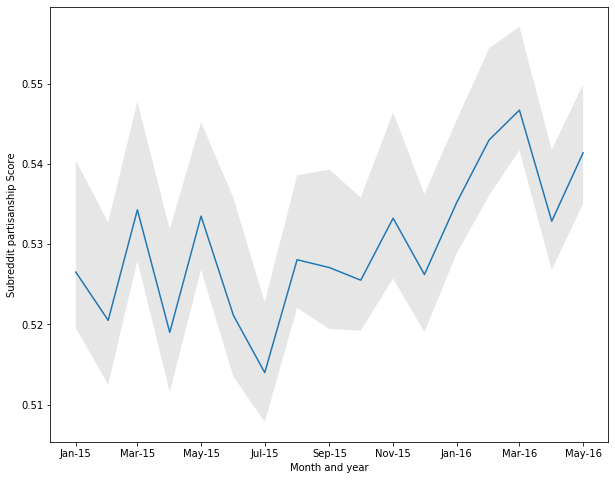

In [237]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(months, pi_vals, linestyle = '-', marker=None)
ax.fill_between(months, pi_vals_ci_below, pi_vals_ci_above, facecolor='0.9', interpolate=True)
ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))
plt.xlabel('Month and year')
plt.ylabel('Subreddit partisanship Score')

plt.show()

## Most polarized subreddits

In [122]:
def fightin_words_unsorted(mat1, mat2, prior = 1):
    vocab_size = mat1.shape[0]
    priors = np.array([prior for i in range(vocab_size)])
    
    z_scores = np.empty(vocab_size)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(mat1)
    n2 = 1.*np.sum(mat2)

    for i in range(vocab_size):
        #compute delta
        term1 = np.log((mat1[i] + priors[i])/(n1 + a0 - mat1[i] - priors[i]))
        term2 = np.log((mat2[i] + priors[i])/(n2 + a0 - mat2[i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(mat1[i] + priors[i]) + 1./(mat2[i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
#     sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in range(len(z_scores)):
        return_list.append(z_scores[i])
        
    return return_list

In [219]:
fightin_words_lists = []

In [220]:
for i in range(17):
    tmp_sanders = sanders_tf_by_month[i].sum(axis=0).A1
    tmp_trump = trump_tf_by_month[i].sum(axis=0).A1
    
    fightin_words_lists.append(fightin_words_unsorted(tmp_trump, tmp_sanders))

In [125]:
def vocab_loss(count_r, count_d):
    sum_r = sum(count_r)
    sum_d = sum(count_d)
    q_r = count_r / sum_r
    q_d = count_d / sum_d
    rho_denom = q_r + q_d
    rho_denom[rho_denom == 0] = 1
    rho = q_r / rho_denom
    r_denom = 1 - q_r
    d_denom = 1 - q_d
    
    vals = np.zeros(count_r.shape[0])
    
    for j in range(count_r.shape[0]):
        if count_r[j] <= 1 or count_d[j] <= 1:
            vals[j] = 0
        else:
            curr_val = np.sum(((q_r / r_denom[j]) * rho) + ((q_d / d_denom[j]) * rho)) - \
(((q_r[j] / r_denom[j]) * rho[j]) + ((q_d[j] / d_denom[j]) * rho[j]))
            
            vals[j] = 0.5 - (0.5 * curr_val)
            
    return vals

In [221]:
polarization_by_month = []

In [222]:
for i in range(17):
    tmp_sanders = sanders_tf_by_month[i].sum(axis=0).A1
    tmp_trump = trump_tf_by_month[i].sum(axis=0).A1
    
    tmp_vals = vocab_loss(tmp_trump, tmp_sanders)
    polarization_by_month.append(tmp_vals)

In [223]:
for i in range(17):
    print(months[i].strftime('%b %Y'))
    display(pd.DataFrame(data = np.array(
            [np.flip([subreddit_names[j] for j in np.argsort(polarization_by_month[i])[-20:]]), 
            [subreddit_names[j] for j in np.argsort(polarization_by_month[i])[:20]]]
            ).T,
             columns = ['Trump', 'Sanders'],
             index = range(1,21)))

Jan 2015


,Trump,Sanders
1,nfl,destinythegame
2,leagueoflegends,bitcoin
3,patriots,politics
4,hockey,askreddit
5,kotakuinaction,funny
6,purplepilldebate,adviceanimals
7,worldnews,conspiracy
8,movies,globaloffensive
9,truechristian,nba
10,bodybuilding,technology


Feb 2015


,Trump,Sanders
1,askreddit,destinythegame
2,nfl,hockey
3,leagueoflegends,politics
4,patriots,squaredcircle
5,fitness,adviceanimals
6,india,roosterteeth
7,kotakuinaction,conspiracy
8,purplepilldebate,funny
9,movies,technology
10,worldnews,planetside


Mar 2015


,Trump,Sanders
1,leagueoflegends,destinythegame
2,nfl,politics
3,askreddit,blackpeopletwitter
4,patriots,hockey
5,fitness,collegebasketball
6,darksouls2,funny
7,news,citiesskylines
8,india,nba
9,silverbugs,bitcoin
10,monsterhunter,pics


Apr 2015


,Trump,Sanders
1,leagueoflegends,politics
2,reds,nba
3,redsox,blackpeopletwitter
4,nfl,hockey
5,patriots,destinythegame
6,india,windowsphone
7,tumblrinaction,funny
8,fatpeoplehate,soccer
9,europe,bitcoin
10,scenesfromahat,worldnews


May 2015


,Trump,Sanders
1,leagueoflegends,politics
2,nfl,destinythegame
3,redsox,kotakuinaction
4,patriots,funny
5,india,relationships
6,fatpeoplehate,bitcoin
7,tumblrinaction,nba
8,bodybuilding,adviceanimals
9,silverbugs,gameofthrones
10,toronto,hockey


Jun 2015


,Trump,Sanders
1,redsox,politics
2,leagueoflegends,hockey
3,europe,destinythegame
4,askreddit,nba
5,golf,relationships
6,patriots,squaredcircle
7,dodgers,blackpeopletwitter
8,nfl,gameofthrones
9,tf2,playark
10,tumblrinaction,witcher


Jul 2015


,Trump,Sanders
1,askreddit,politics
2,nfl,destinythegame
3,redsox,nba
4,movies,fivenightsatfreddys
5,leagueoflegends,squaredcircle
6,globalpowers,pcmasterrace
7,tumblrinaction,blackpeopletwitter
8,golf,soccer
9,bodybuilding,buccos
10,tf2,windowsphone


Aug 2015


,Trump,Sanders
1,stevenuniverse,politics
2,torontobluejays,squaredcircle
3,patriots,wow
4,nfl,destinythegame
5,worldnews,pcmasterrace
6,askreddit,kotakuinaction
7,movies,newyorkmets
8,europe,relationships
9,globalpowers,blackpeopletwitter
10,globaloffensive,seattle


Sep 2015


,Trump,Sanders
1,nfl,politics
2,patriots,destinythegame
3,stevenuniverse,videos
4,globalpowers,relationships
5,worldnews,squaredcircle
6,movies,windowsphone
7,askreddit,buccos
8,eve,showerthoughts
9,redsox,xboxone
10,cfb,trees


Oct 2015


,Trump,Sanders
1,nfl,politics
2,worldnews,blackpeopletwitter
3,stevenuniverse,destinythegame
4,fallout,military
5,patriots,fantasyfootball
6,kansascitychiefs,relationships
7,dodgers,xboxone
8,askreddit,todayilearned
9,4chan,politicaldiscussion
10,eve,technology


Nov 2015


,Trump,Sanders
1,nfl,politics
2,sex,military
3,patriots,todayilearned
4,fo4,halo
5,worldnews,fantasyfootball
6,news,conspiracy
7,mma,nba
8,teenagers,blackpeopletwitter
9,opieandanthony,xboxone
10,kansascitychiefs,politicaldiscussion


Dec 2015


,Trump,Sanders
1,nfl,politics
2,news,conspiracy
3,mma,socialism
4,askreddit,cfb
5,kotakuinaction,military
6,drama,xboxone
7,worldnews,todayilearned
8,patriots,adviceanimals
9,opieandanthony,politicaldiscussion
10,sex,canada


Jan 2016


,Trump,Sanders
1,nfl,politics
2,worldnews,socialism
3,patriots,military
4,askreddit,cfb
5,news,nba
6,movies,todayilearned
7,teenagers,xboxone
8,fitness,starcraft
9,kotakuinaction,videos
10,relationship_advice,adviceanimals


Feb 2016


,Trump,Sanders
1,askreddit,politics
2,worldnews,socialism
3,news,military
4,squaredcircle,blackpeopletwitter
5,teenagers,nba
6,mma,cfb
7,drama,adviceanimals
8,canada,collegebasketball
9,vaporents,worldpolitics
10,nfl,hockey


Mar 2016


,Trump,Sanders
1,askreddit,politics
2,drama,hockey
3,teenagers,collegebasketball
4,asktrumpsupporters,socialism
5,fireemblem,pcmasterrace
6,worldnews,gifs
7,thedivision,military
8,movies,blackpeopletwitter
9,nfl,soccer
10,conservative,legaladvice


Apr 2016


,Trump,Sanders
1,askreddit,politics
2,redsox,hockey
3,drama,pcmasterrace
4,golf,politicaldiscussion
5,reds,socialism
6,nba,cfb
7,worldnews,christianity
8,teenagers,military
9,squaredcircle,starwars
10,cringeanarchy,nrl


May 2016


,Trump,Sanders
1,nba,okcupid
2,redsox,pcmasterrace
3,politicaldiscussion,hockey
4,askreddit,socialism
5,motorcycles,military
6,mr_trump,cfb
7,golf,politics
8,news,gifs
9,canada,mariners
10,conservative,overwatch


In [169]:
polarization_by_month[-1][subreddit_reverse_dict['askreddit']]

0.0006321479028237875

In [168]:
fightin_words_lists[-1][subreddit_reverse_dict['askreddit']]

-7.728682382816713

In [179]:
print(sanders_tf_by_month[-2].sum(axis=0).A1[subreddit_reverse_dict['askreddit']]/sanders_tf_by_month[-2].sum())
print(trump_tf_by_month[-2].sum(axis=0).A1[subreddit_reverse_dict['askreddit']]/trump_tf_by_month[-2].sum())

0.05975409297126701
0.06413516146662548


In [230]:
[subreddit_names[j] for j in np.argsort(fightin_words_lists[14])[-20:]]

['vaporents',
 'catholicism',
 'roastme',
 'enoughsandersspam',
 'unitedkingdom',
 'capitalismvsocialism',
 'de',
 'flyers',
 'dc_cinematic',
 '4chan',
 'askreddit',
 'canada',
 'conservative',
 'kotakuinaction',
 'cringeanarchy',
 'fireemblem',
 'thedivision',
 'asktrumpsupporters',
 'teenagers',
 'drama']

In [224]:
for i in range(17):
    print(months[i].strftime('%b %Y'))
    display(pd.DataFrame(data = np.array(
            [np.flip([subreddit_names[j] for j in np.argsort(fightin_words_lists[i])[-20:]]), 
            [subreddit_names[j] for j in np.argsort(fightin_words_lists[i])[:20]]]
            ).T,
             columns = ['Trump', 'Sanders'],
             index = range(1,21)))

Jan 2015


,Trump,Sanders
1,nfl,askreddit
2,kotakuinaction,destinythegame
3,leagueoflegends,politics
4,purplepilldebate,funny
5,truechristian,adviceanimals
6,bodybuilding,bitcoin
7,hockey,news
8,debatereligion,pics
9,patriots,globaloffensive
10,christianity,nba


Feb 2015


,Trump,Sanders
1,patriots,askreddit
2,fitness,destinythegame
3,india,politics
4,purplepilldebate,adviceanimals
5,leagueoflegends,funny
6,anarcho_capitalism,hockey
7,darksouls2,squaredcircle
8,christianity,news
9,tumblrinaction,pics
10,monsterhunter,technology


Mar 2015


,Trump,Sanders
1,leagueoflegends,politics
2,patriots,askreddit
3,monsterhunter,destinythegame
4,india,funny
5,darksouls2,hockey
6,dfo,pics
7,fitness,blackpeopletwitter
8,silverbugs,collegebasketball
9,anarcho_capitalism,worldnews
10,fatpeoplehate,bitcoin


Apr 2015


,Trump,Sanders
1,leagueoflegends,askreddit
2,reds,politics
3,redsox,nba
4,india,hockey
5,patriots,blackpeopletwitter
6,europe,funny
7,nfl,worldnews
8,scenesfromahat,destinythegame
9,bodybuilding,todayilearned
10,australia,news


May 2015


,Trump,Sanders
1,leagueoflegends,politics
2,nfl,askreddit
3,patriots,funny
4,redsox,kotakuinaction
5,india,destinythegame
6,toronto,adviceanimals
7,realestate,nba
8,bodybuilding,news
9,tf2,hockey
10,dodgers,bitcoin


Jun 2015


,Trump,Sanders
1,redsox,politics
2,europe,nba
3,leagueoflegends,askreddit
4,golf,destinythegame
5,bodybuilding,hockey
6,tf2,squaredcircle
7,patriots,gameofthrones
8,torontobluejays,blackpeopletwitter
9,dodgers,todayilearned
10,india,videos


Jul 2015


,Trump,Sanders
1,redsox,politics
2,globalpowers,askreddit
3,golf,destinythegame
4,bodybuilding,nba
5,tf2,news
6,toronto,pics
7,progolf,squaredcircle
8,patriots,videos
9,anarcho_capitalism,soccer
10,india,pcmasterrace


Aug 2015


,Trump,Sanders
1,torontobluejays,politics
2,patriots,squaredcircle
3,stevenuniverse,askreddit
4,europe,wow
5,globalpowers,pcmasterrace
6,globaloffensive,kotakuinaction
7,economics,blackpeopletwitter
8,redsox,destinythegame
9,bodybuilding,relationships
10,eve,pics


Sep 2015


,Trump,Sanders
1,patriots,politics
2,globalpowers,destinythegame
3,stevenuniverse,videos
4,torontobluejays,squaredcircle
5,eve,askreddit
6,kansascitychiefs,todayilearned
7,circlejerk,news
8,europe,relationships
9,globaloffensive,pics
10,49ers,adviceanimals


Oct 2015


,Trump,Sanders
1,fallout,politics
2,dodgers,askreddit
3,patriots,todayilearned
4,stevenuniverse,blackpeopletwitter
5,eve,fantasyfootball
6,nfl,destinythegame
7,torontobluejays,military
8,teenagers,adviceanimals
9,4chan,relationships
10,kansascitychiefs,technology


Nov 2015


,Trump,Sanders
1,sex,politics
2,patriots,askreddit
3,teenagers,todayilearned
4,opieandanthony,fantasyfootball
5,kansascitychiefs,conspiracy
6,nfl,nba
7,globalpowers,adviceanimals
8,conservative,halo
9,bindingofisaac,military
10,stlouis,blackpeopletwitter


Dec 2015


,Trump,Sanders
1,kotakuinaction,politics
2,drama,conspiracy
3,opieandanthony,cfb
4,patriots,todayilearned
5,sex,adviceanimals
6,conservative,askreddit
7,teenagers,politicaldiscussion
8,4chan,military
9,globalpowers,canada
10,houston,videos


Jan 2016


,Trump,Sanders
1,patriots,politics
2,teenagers,cfb
3,kotakuinaction,todayilearned
4,relationship_advice,nba
5,drama,videos
6,kansascitychiefs,military
7,fitness,adviceanimals
8,opieandanthony,politicaldiscussion
9,thedivision,gifs
10,minnesotavikings,askreddit


Feb 2016


,Trump,Sanders
1,teenagers,politics
2,drama,blackpeopletwitter
3,squaredcircle,nba
4,canada,socialism
5,vaporents,adviceanimals
6,thedivision,cfb
7,cringeanarchy,hockey
8,de,hiphopheads
9,india,military
10,economics,technology


Mar 2016


,Trump,Sanders
1,drama,politics
2,teenagers,hockey
3,asktrumpsupporters,collegebasketball
4,thedivision,pcmasterrace
5,fireemblem,gifs
6,cringeanarchy,blackpeopletwitter
7,kotakuinaction,socialism
8,conservative,military
9,canada,soccer
10,askreddit,legaladvice


Apr 2016


,Trump,Sanders
1,drama,politics
2,golf,hockey
3,reds,pcmasterrace
4,redsox,politicaldiscussion
5,teenagers,christianity
6,cringeanarchy,starwars
7,conservative,cfb
8,flyers,socialism
9,bettercallsaul,hiphopheads
10,vaporents,military


May 2016


,Trump,Sanders
1,nba,pcmasterrace
2,redsox,hockey
3,motorcycles,politics
4,canada,cfb
5,conservative,military
6,drama,socialism
7,golf,christianity
8,mapporn,okcupid
9,teenagers,gifs
10,mr_trump,overwatch


In [239]:
# adapted from https://gist.github.com/xandaschofield/3c4070b2f232b185ce6a09e47b4e7473
def make_plot(x_vals, y_vals, sig_val, ylab):
    cmap = plt.get_cmap('bwr')
    colors = []
    annots = []
    for i, y in enumerate(y_vals):
        if y > sig_val:
            colors.append(cmap(0.999))
            annots.append(subreddit_names[i])
        elif y < -sig_val:
            colors.append(cmap(0))
            annots.append(subreddit_names[i])
        else:
            colors.append(cmap((y/(2*sig_val)) + 0.5))
            annots.append(None)

    fig, ax = plt.subplots(figsize=(10,8))
    plt.scatter(x_vals, y_vals, c=colors, linewidth=0, cmap = plt.get_cmap('bwr'))
    for i, annot in enumerate(annots):
        if annot is not None:
            ax.annotate(annot, (x_vals[i], y_vals[i]), color=colors[i])
    ax.set_xscale('log')
    plt.ylim((-1.05 * max(np.abs(y_vals)), 1.05 * max(np.abs(y_vals))))
    plt.xlim((10, 10 ** 5))
    plt.xlabel('Frequency of subreddit, log scale')
    plt.ylabel(ylab)
    
    plt.show()

In [225]:
for i in range(17):
    tmp_sanders = sanders_tf_by_month[i].sum(axis=0).A1
    tmp_trump = trump_tf_by_month[i].sum(axis=0).A1
    
    make_plot(tmp_sanders + tmp_trump, fightin_words_lists[i], sorted(fightin_words_lists[i])[-10])

Jan 2015


TypeError: make_plot() missing 1 required positional argument: 'ylab'

Jan 2015


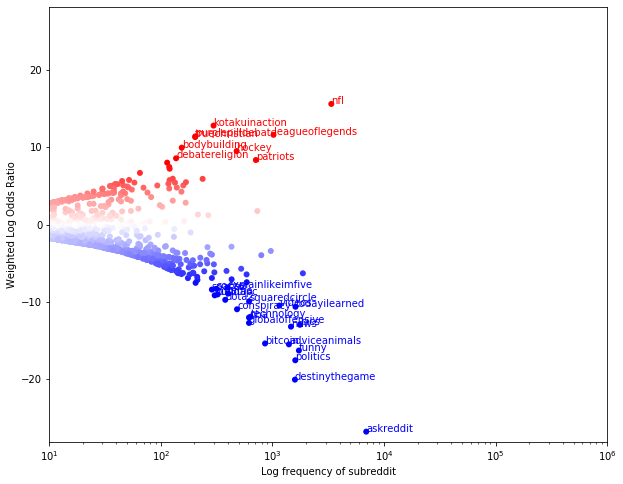

Feb 2015


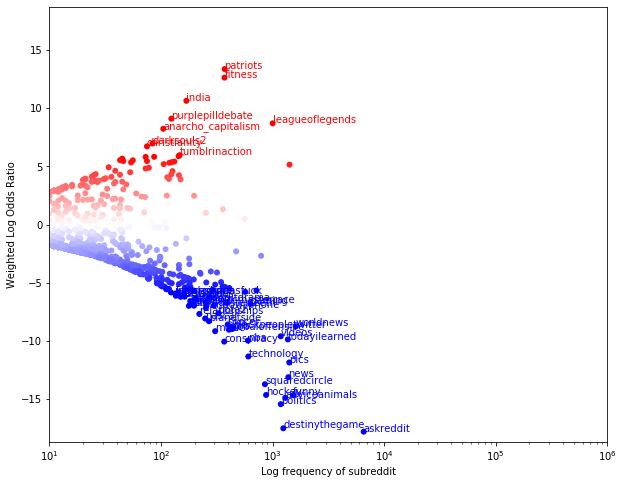

Mar 2015


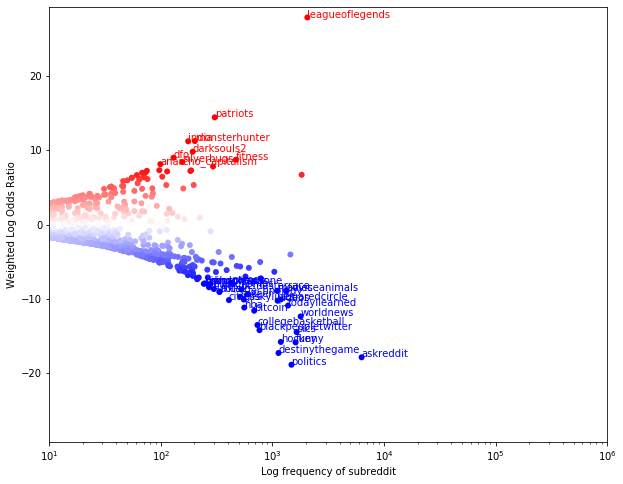

Apr 2015


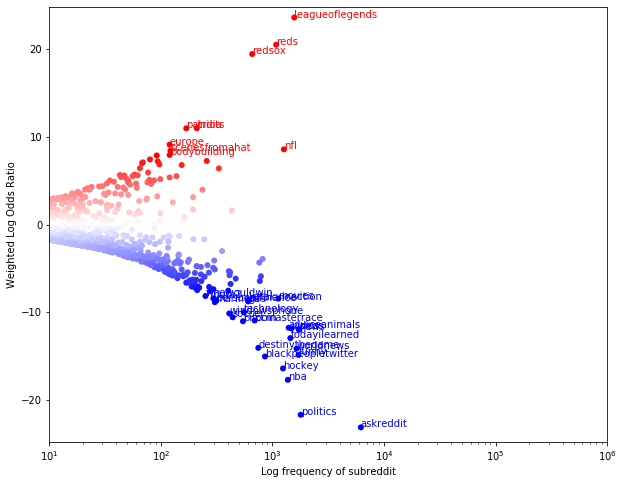

May 2015


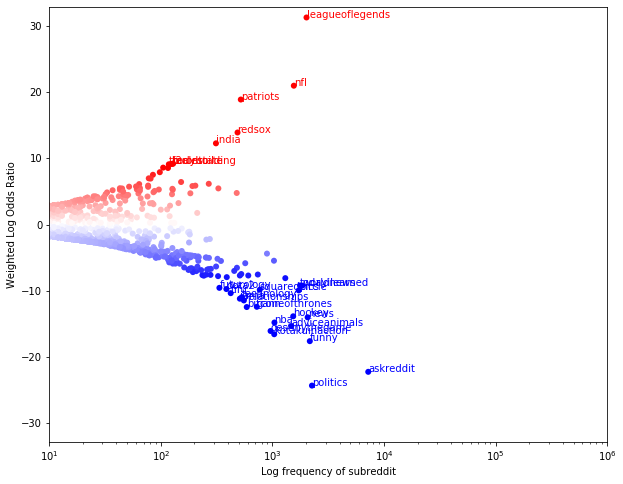

Jun 2015


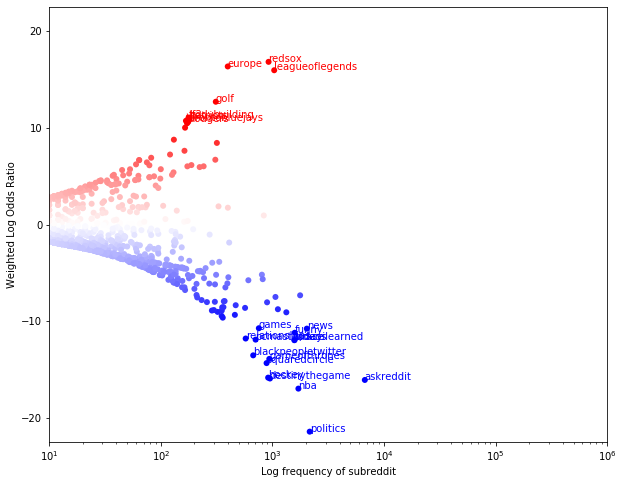

Jul 2015


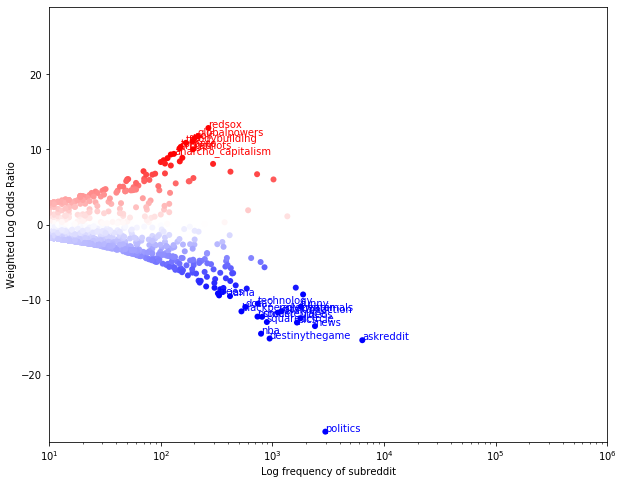

Aug 2015


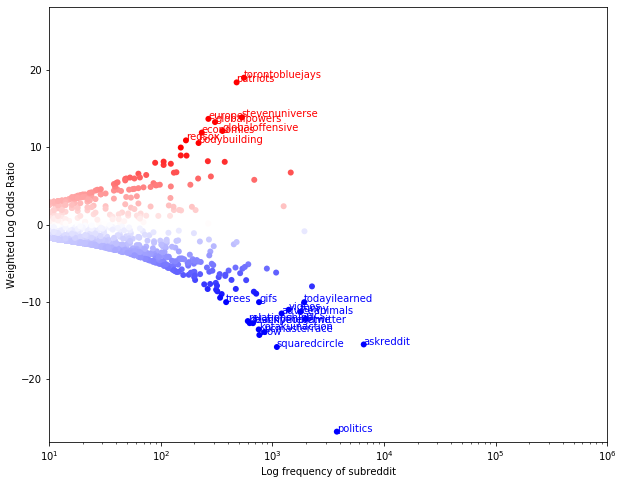

Sep 2015


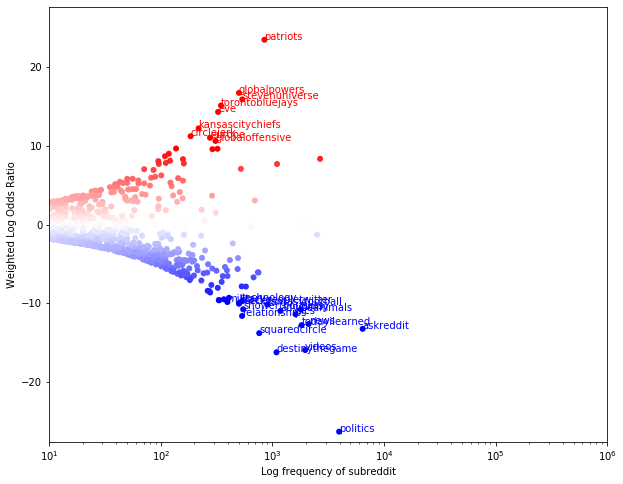

Oct 2015


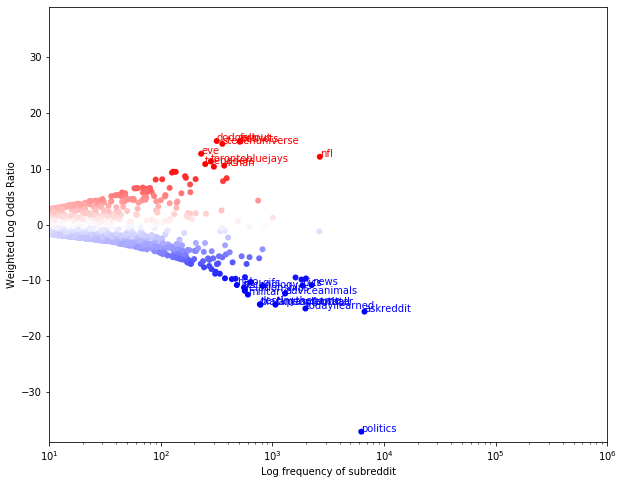

Nov 2015


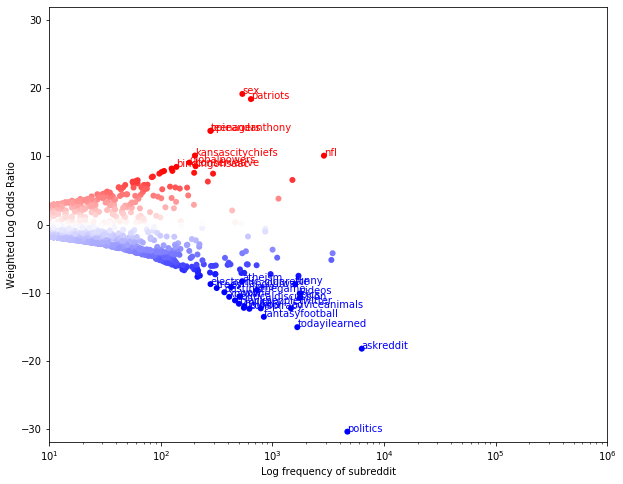

Dec 2015


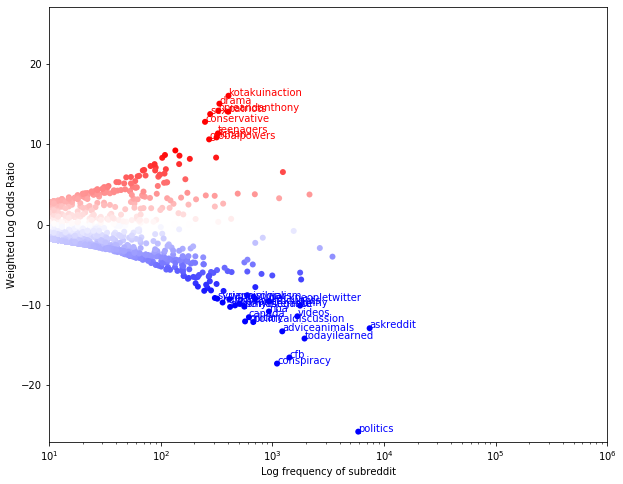

Jan 2016


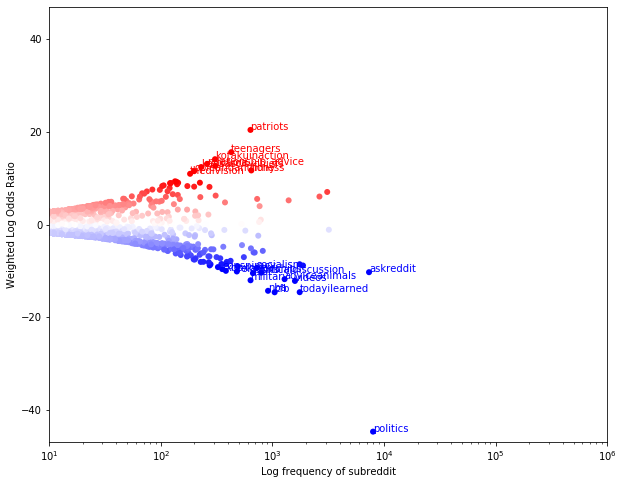

Feb 2016


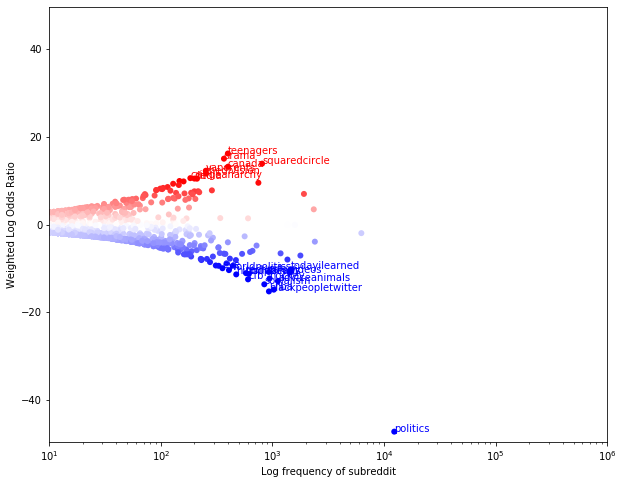

Mar 2016


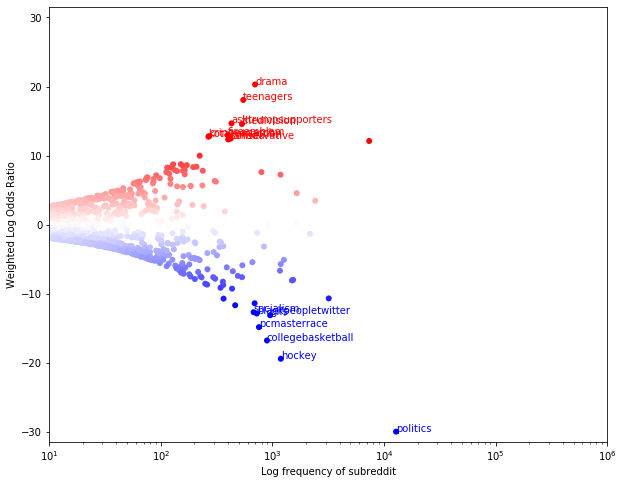

Apr 2016


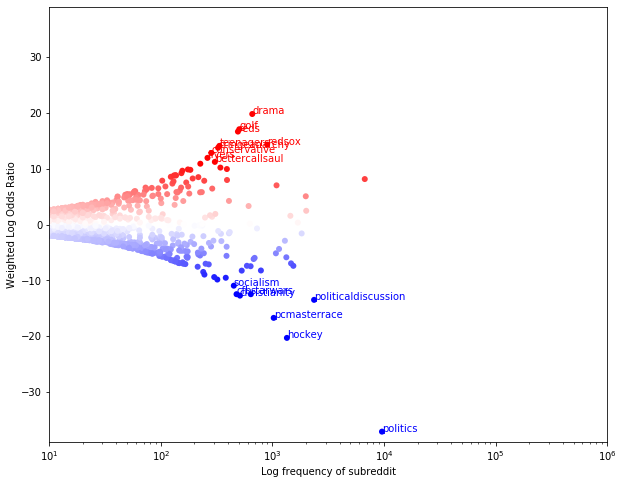

May 2016


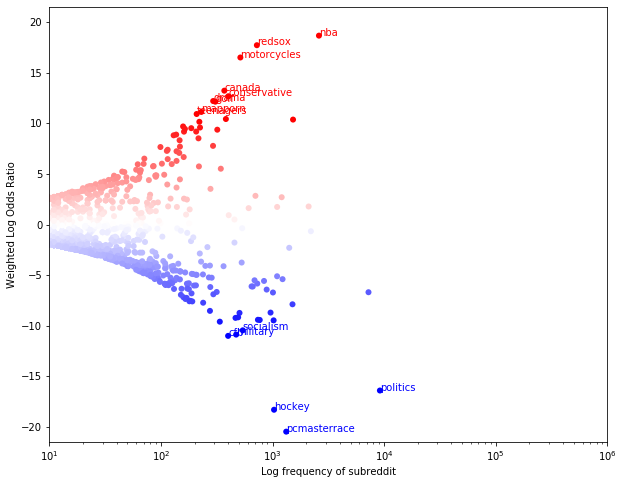

In [226]:
for i in range(17):
    print(months[i].strftime('%b %Y'))
    tmp_sanders = sanders_tf_by_month[i].sum(axis=0).A1
    tmp_trump = trump_tf_by_month[i].sum(axis=0).A1
    
    make_plot(tmp_sanders + tmp_trump, fightin_words_lists[i], sorted(fightin_words_lists[i])[-10], 'Weighted Log Odds Ratio')

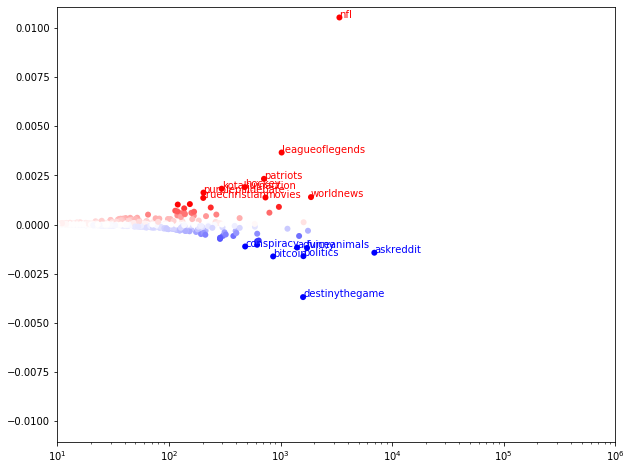

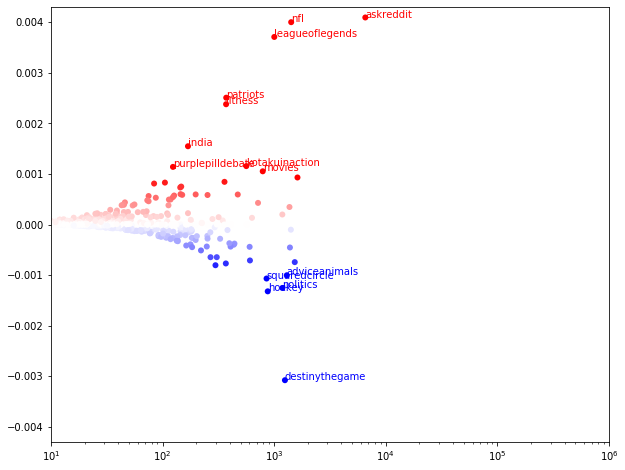

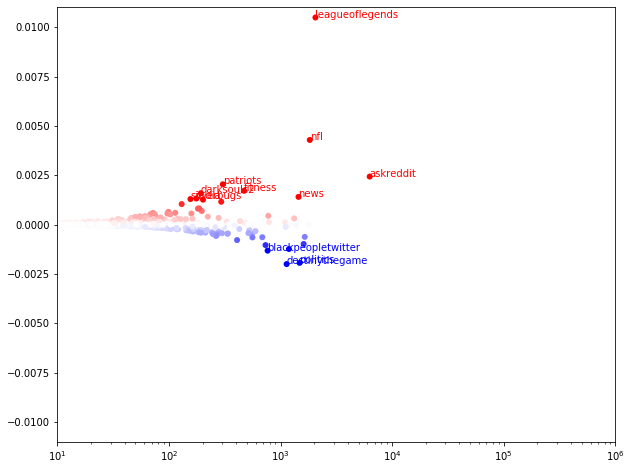

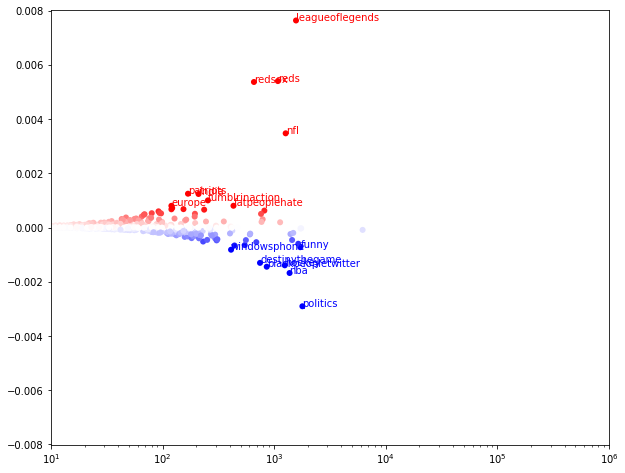

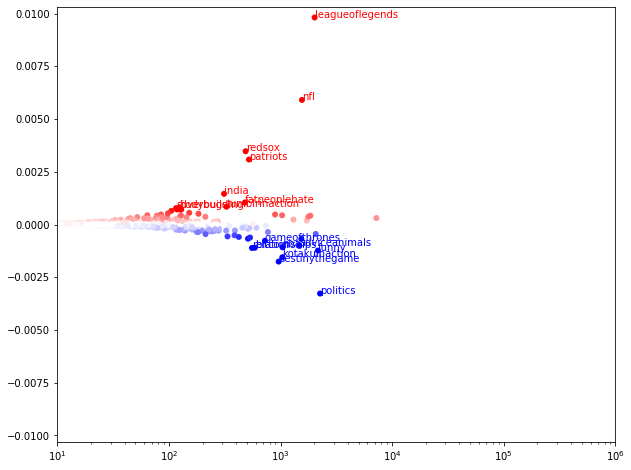

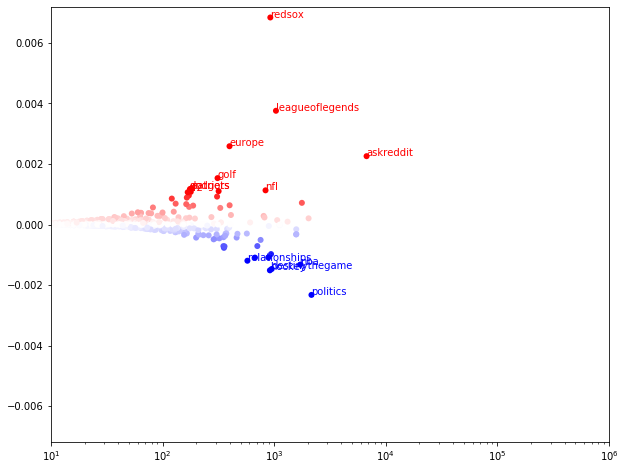

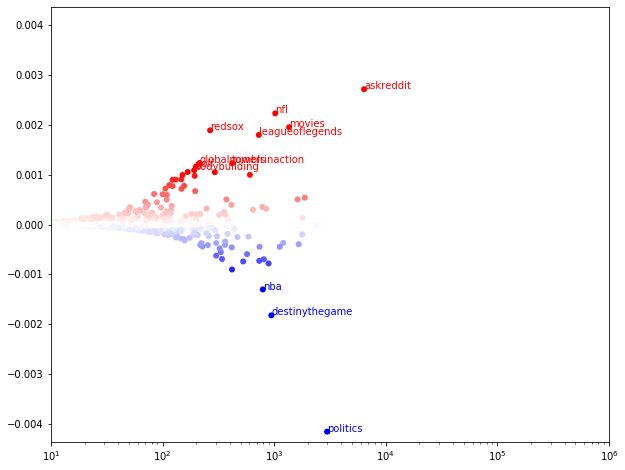

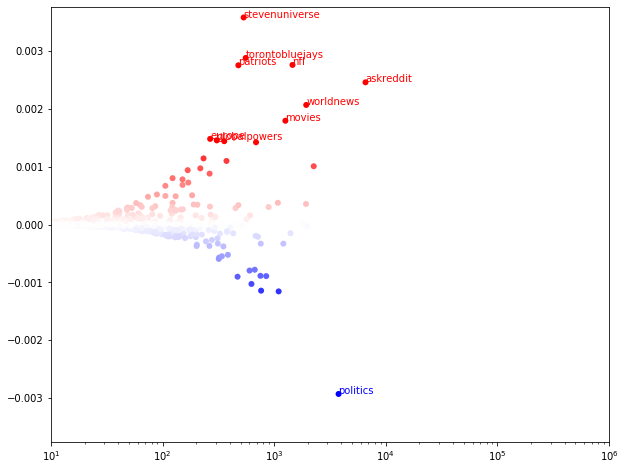

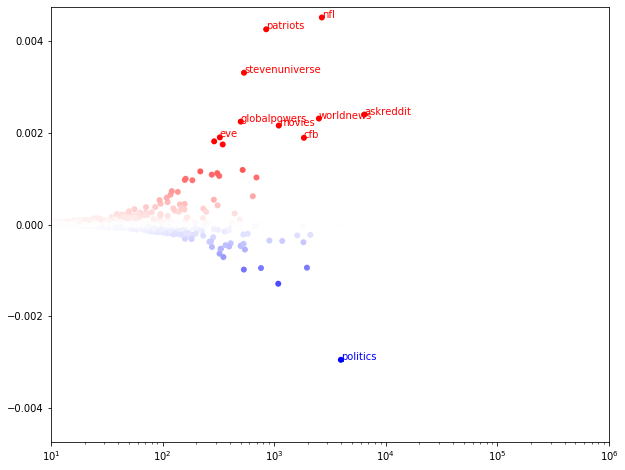

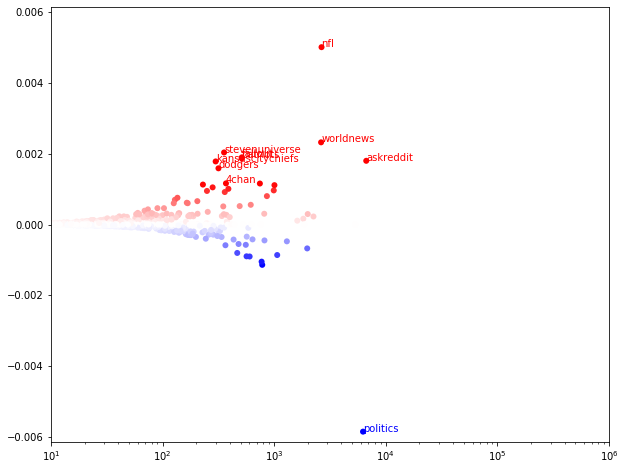

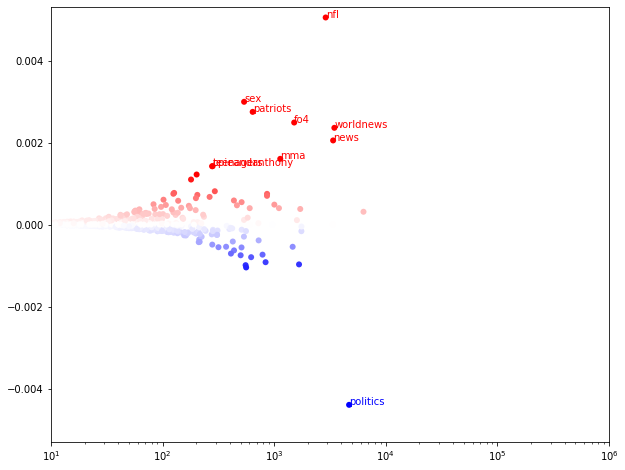

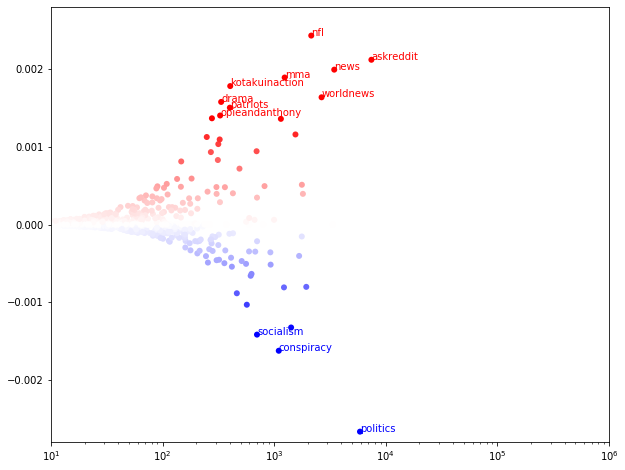

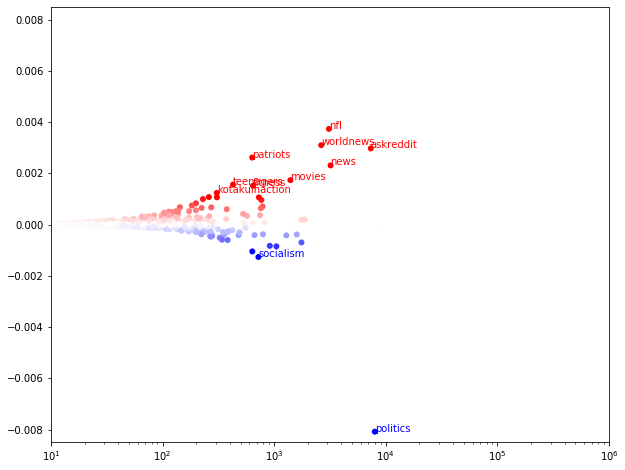

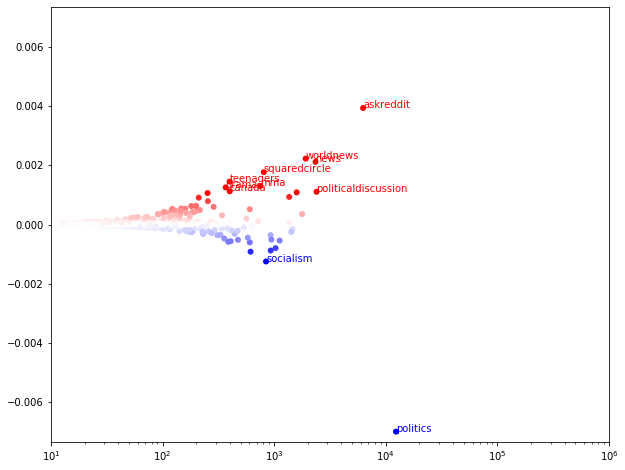

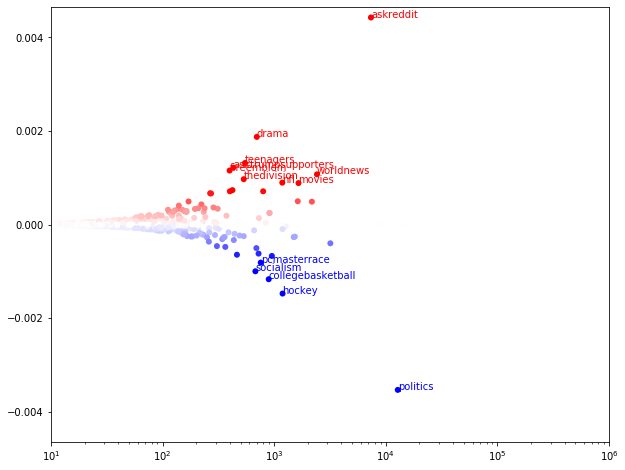

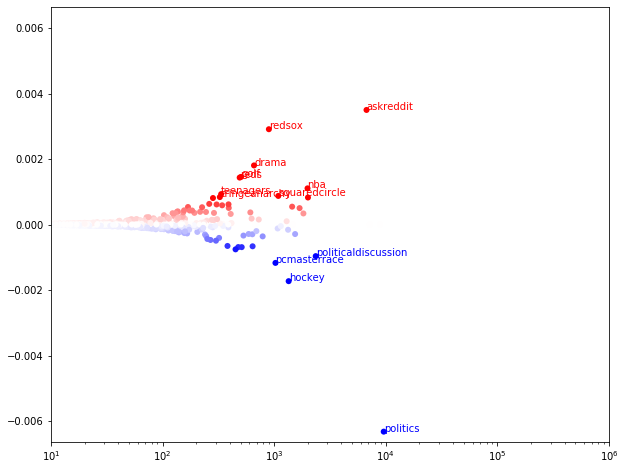

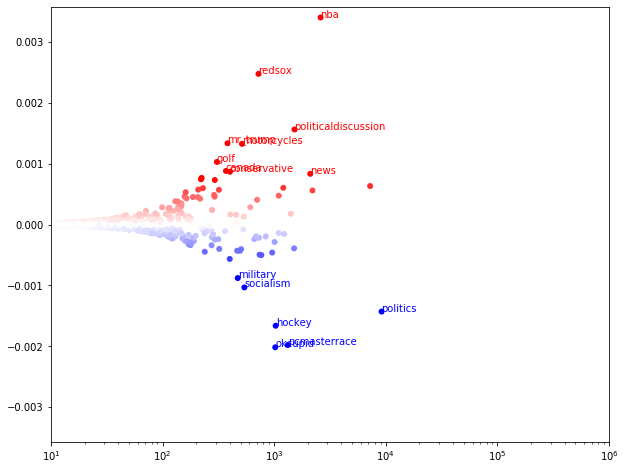

In [135]:
for i in range(17):
    tmp_sanders = sanders_tf_by_month[i].sum(axis=0).A1
    tmp_trump = trump_tf_by_month[i].sum(axis=0).A1
    
    make_plot(tmp_sanders + tmp_trump, polarization_by_month[i], sorted(polarization_by_month[i])[-10])

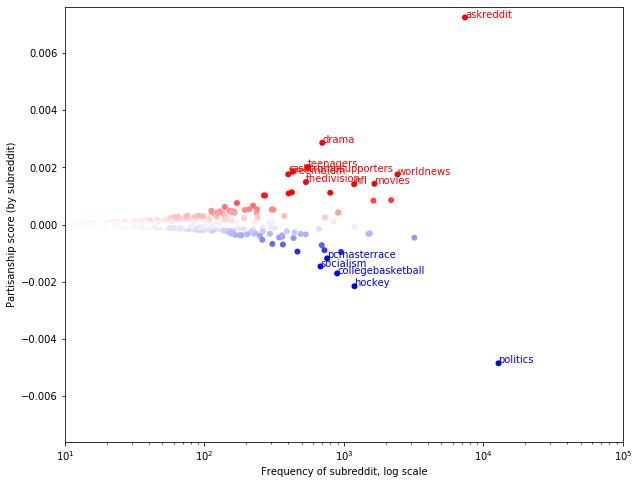

In [240]:
tmp_sanders = sanders_tf_by_month[14].sum(axis=0).A1
tmp_trump = trump_tf_by_month[14].sum(axis=0).A1

make_plot(tmp_sanders + tmp_trump, polarization_by_month[14], sorted(polarization_by_month[14])[-10], 'Partisanship score (by subreddit)')

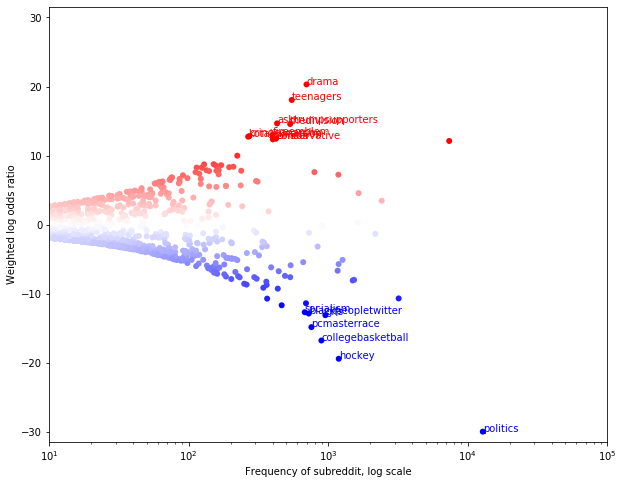

In [241]:
tmp_sanders = sanders_tf_by_month[14].sum(axis=0).A1
tmp_trump = trump_tf_by_month[14].sum(axis=0).A1

make_plot(tmp_sanders + tmp_trump, fightin_words_lists[14], sorted(fightin_words_lists[14])[-10], 'Weighted log odds ratio')


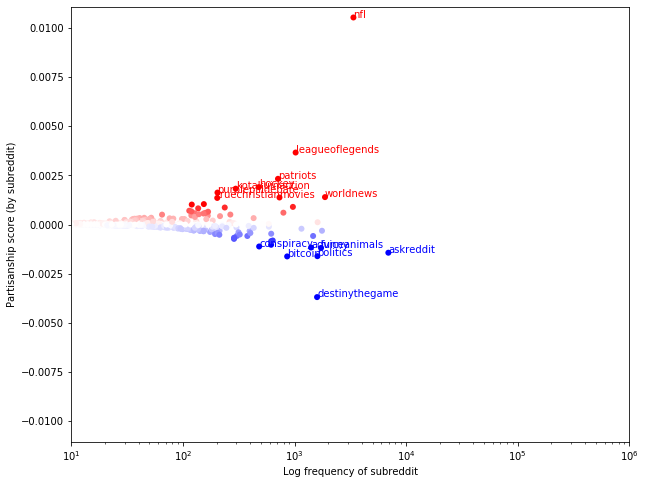

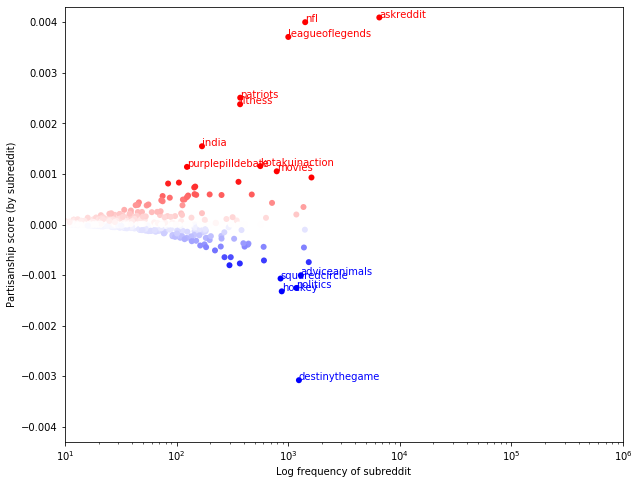

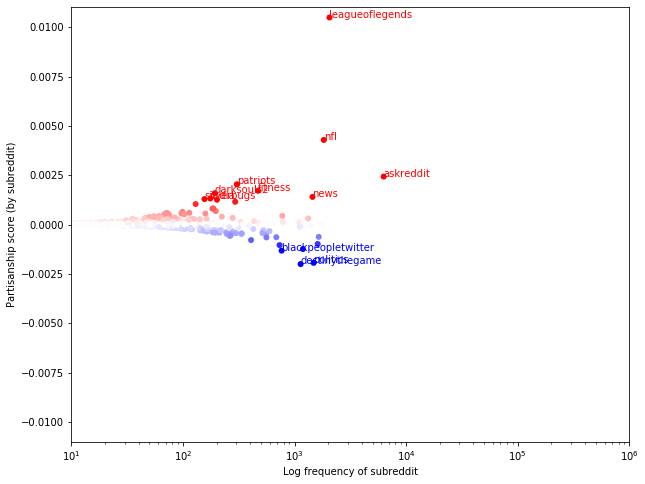

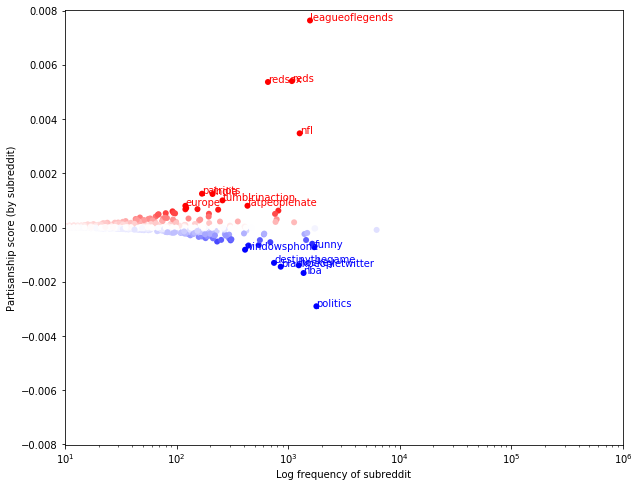

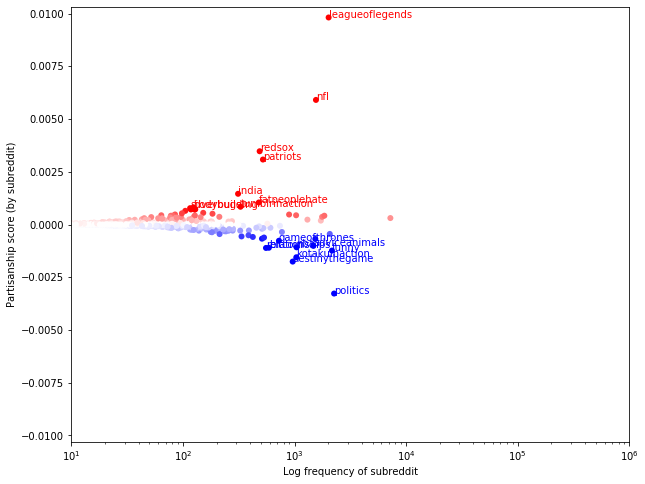

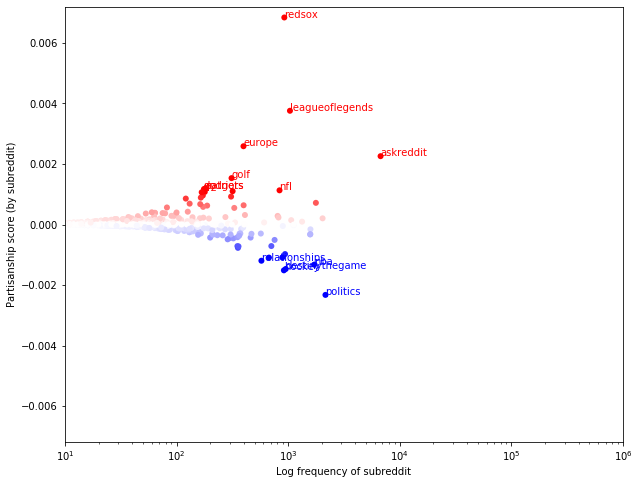

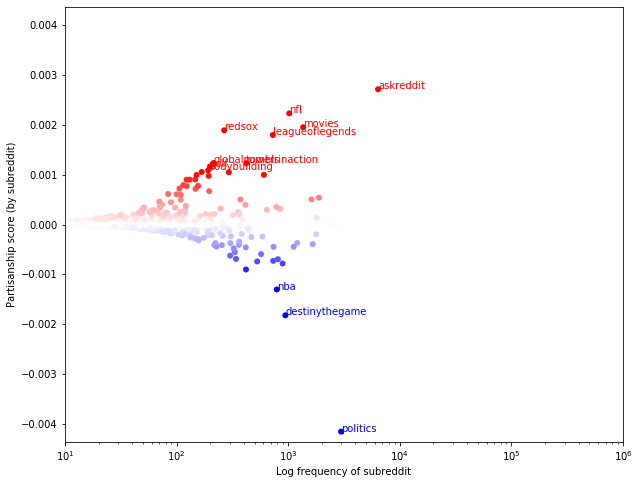

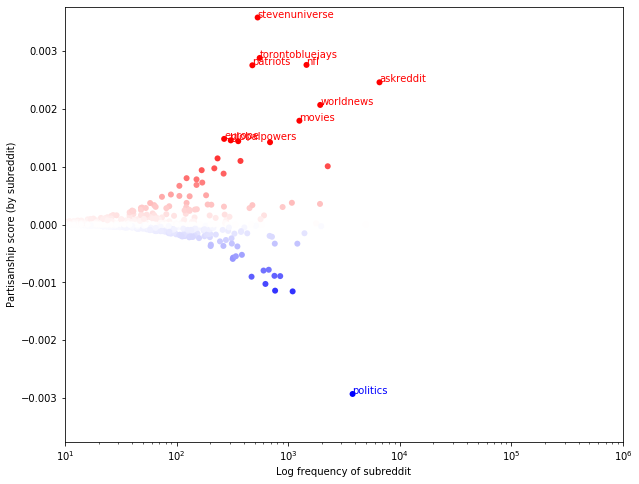

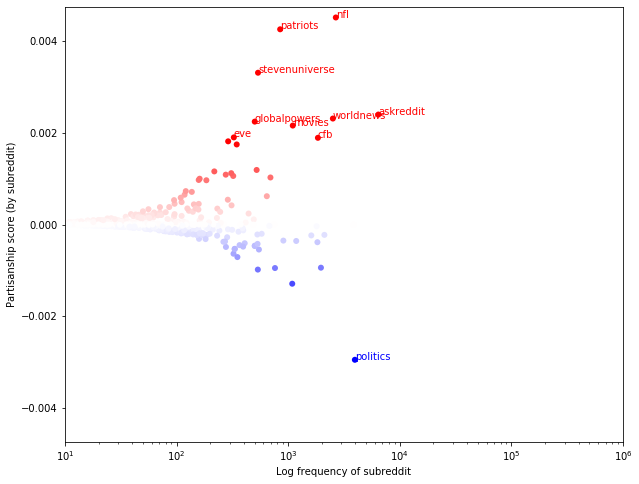

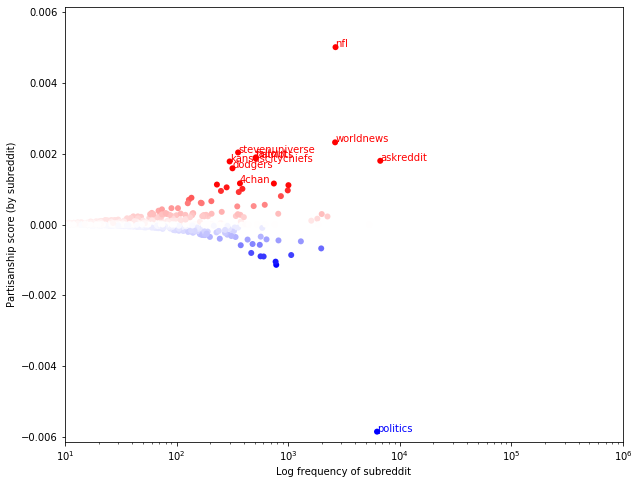

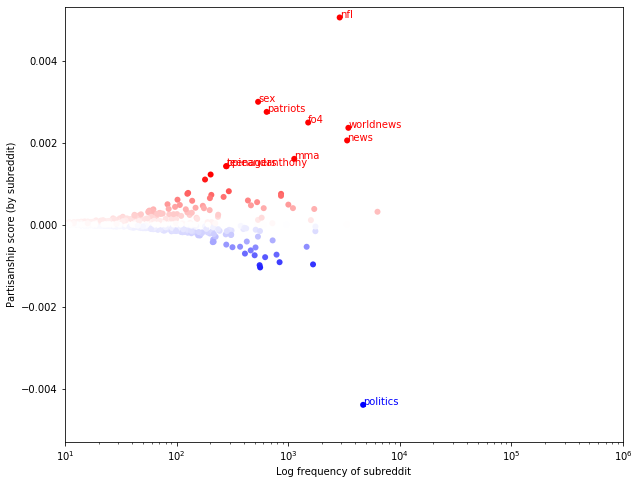

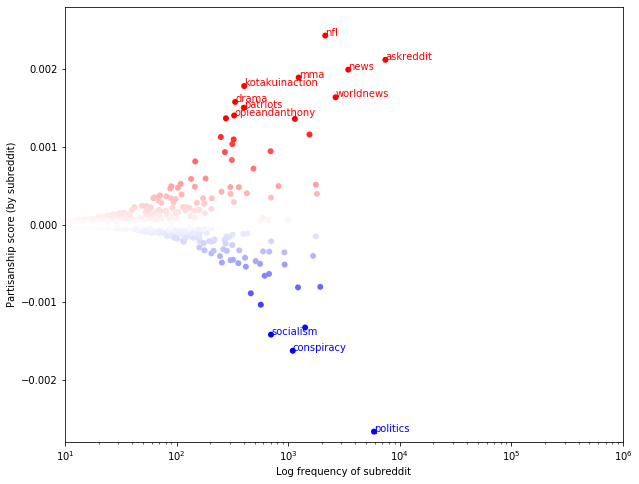

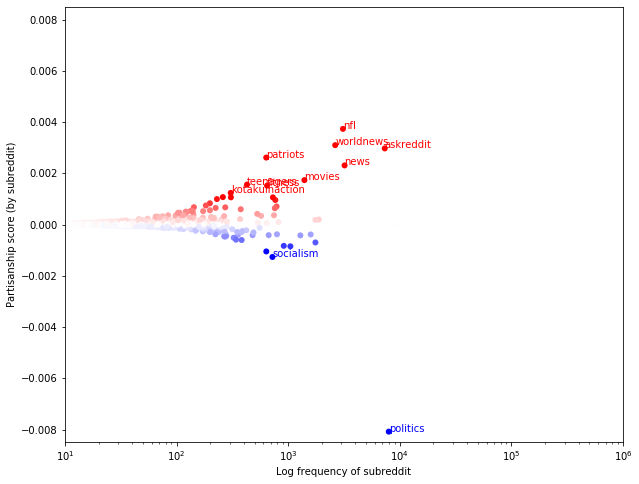

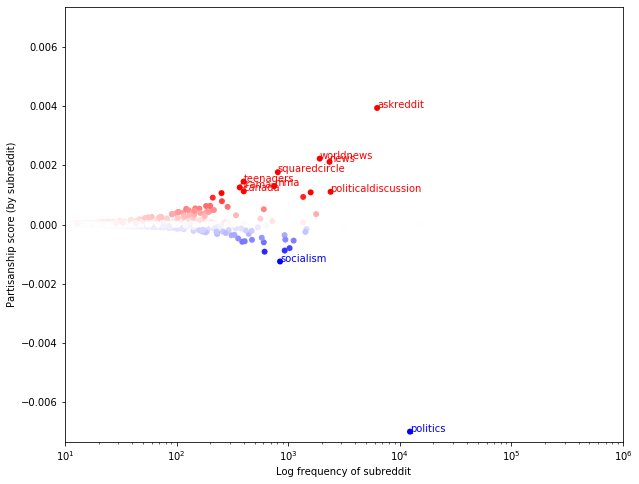

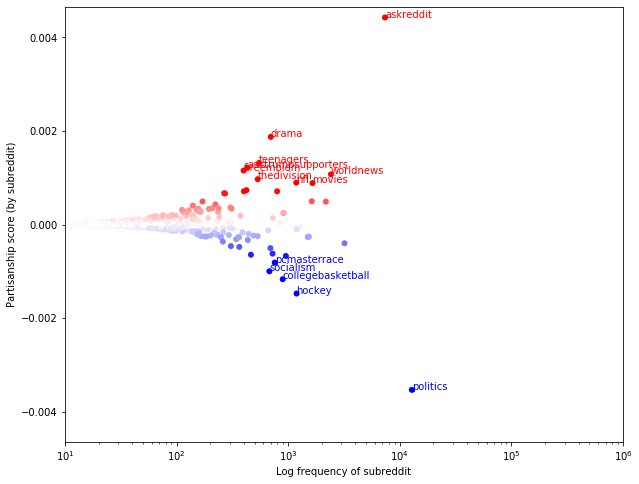

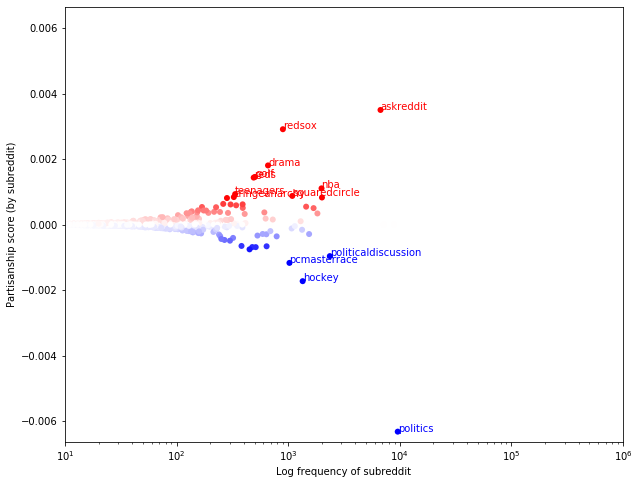

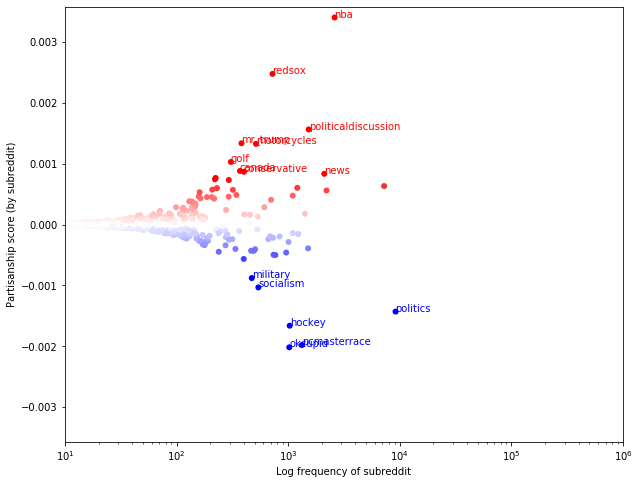

In [196]:
for i in range(17):
    tmp_sanders = sanders_tf_by_month[i].sum(axis=0).A1
    tmp_trump = trump_tf_by_month[i].sum(axis=0).A1
    
    make_plot(tmp_sanders + tmp_trump, polarization_by_month[i], sorted(polarization_by_month[i])[-10], 'Partisanship score (by subreddit)')

## Polarization by user

In [215]:
def calculate_polarization_user(dem_counts, rep_counts):
    dem_no = dem_counts.shape[0]
    rep_no = rep_counts.shape[0]    
    
    dem_user_total = dem_counts.sum(axis=1)
    rep_user_total = rep_counts.sum(axis=1)
    
    # equivalent to dem_counts / dem_user_total
    dem_user_distr = (diags(1 / dem_user_total.A.ravel())).dot(dem_counts)  # get row-wise distributions
    rep_user_distr = (diags(1 / rep_user_total.A.ravel())).dot(rep_counts)
    assert (set(dem_user_total.nonzero()[0]) == set(range(dem_no)))  # make sure there are no zero rows
    assert (set(rep_user_total.nonzero()[0]) == set(range(rep_no)))  # make sure there are no zero rows

    dem_q = get_party_q(dem_counts)
    rep_q = get_party_q(rep_counts)

    # apply measures via leave-out
    dem_addup = []
    rep_addup = []
    
    for i in range(dem_no):
        dem_leaveout_q = get_party_q(dem_counts, i)
        token_scores_dem = 1. - get_rho(dem_leaveout_q, rep_q)
        dem_addup.append(dem_user_distr[i, :].dot(token_scores_dem)[0, 0])
    
    for i in range(rep_no):
        rep_leaveout_q = get_party_q(rep_counts, i)
        token_scores_rep = get_rho(dem_q, rep_leaveout_q)
        rep_addup.append(rep_user_distr[i, :].dot(token_scores_rep)[0, 0])
    return dem_addup, rep_addup

In [216]:
pi_vals_sanders_user = []
pi_vals_trump_user = []

In [217]:
for i in range(17):
    print(i)
    sanders_indices_curr = sanders_tf_by_month[i].sum(axis=1).nonzero()[0]
    trump_indices_curr = trump_tf_by_month[i].sum(axis=1).nonzero()[0]
    sanders_mat = sanders_tf_by_month[i][sanders_indices_curr,:]
    trump_mat = trump_tf_by_month[i][trump_indices_curr,:]
    
    pi_vals_curr_sanders, pi_vals_curr_trump = calculate_polarization_user(sanders_mat, trump_mat)
    
    sanders_pi_curr = np.zeros(sanders_tf_by_month[i].shape[0])
    trump_pi_curr = np.zeros(trump_tf_by_month[i].shape[0])
    
    for j in range(len(sanders_indices_curr)):
        sanders_pi_curr[sanders_indices_curr[j]] = pi_vals_curr_sanders[j]
        
    for j in range(len(trump_indices_curr)):
        trump_pi_curr[trump_indices_curr[j]] = pi_vals_curr_trump[j]
        
#     print(len(sanders_pi_curr))
#     print(len(trump_pi_curr))
    pi_vals_sanders_user.append(sanders_pi_curr)
    pi_vals_trump_user.append(trump_pi_curr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [218]:
with open("stored_variables/subreddit_polarization_user_sanders.pickle", "wb") as f:
    pickle.dump(pi_vals_sanders_user, f)
    
with open("stored_variables/subreddit_polarization_user_trump.pickle", "wb") as f:
    pickle.dump(pi_vals_trump_user, f)